# Evolution of urban patterns: urban morphology as an open reproducible data science

## Plot maps

This is the third notebook in a sequence of three. The notebook plots maps of case studies.

It requires `data/case_studies.csv` input with origins of case studies and data generated by the first notebook.

Date: February 5, 2021

---

We start with the import of libraries used in this notebook.

In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import pathlib
from palettable.wesanderson import Moonrise5_6

`glob` will give us a list of all GeoPackages, while `cases` represent the original input CSV.

In [2]:
files = glob.glob("data/*gpkg")
cases = pd.read_csv("data/case_studies3.csv")
cases = cases.set_index("case")

This cell loops through all files, loads all its layers and plots the map of the case study within 400 m buffer around the origin point as used in the statistical analysis.

In [3]:
%%capture --no-stdout

for f in files:
    tessellation = gpd.read_file(f, layer="tessellation")
    buildings = gpd.read_file(f, layer="buildings")
    edges = gpd.read_file(f, layer="edges")
    nodes = gpd.read_file(f, layer="nodes")
    case = pathlib.Path(f).stem
    coords = cases.origin.loc[case]
    buffer = gpd.GeoSeries([Point(tuple(map(float, coords[1:-1].split(', '))))], crs=4326).to_crs(tessellation.crs).buffer(400)
    ax = gpd.clip(buildings, buffer).plot(zorder=1, color=Moonrise5_6.hex_colors[3], figsize=(12, 12))
    buildings.plot(ax=ax, zorder=0, color=Moonrise5_6.hex_colors[3], alpha=.2)
    buffer.plot(ax=ax, facecolor="none", edgecolor=Moonrise5_6.hex_colors[4], linewidth=2)
    ax.set_axis_off()
    ax.set_title(case)
    b = buffer.total_bounds
    ax.set_xlim(b[0]-20, b[2]+20)
    ax.set_ylim(b[1]-20, b[3]+20)
    plt.savefig(f"figures/{case}.png", bbox_inches="tight")
    plt.close("all")

Figures in the paper use only a sample of cases.

In [4]:
sample = [
    'data/Connaught Place.gpkg',
    'data/Koramangala.gpkg',
    'data/Nampally.gpkg',
    'data/HITEC City.gpkg',
    'data/Shivajinagar.gpkg',
    'data/Vijay Nagar.gpkg',
]
periods = [
    "pre-industrial",
    "industrial",
    "garden city",
    "modernist",
    "neo-traditional",
    "informal"
]

We plot the same maps as above, just all 6 samples on the same figure.

In [5]:
%%capture --no-stdout

fig, axs = plt.subplots(2, 3, figsize=(8, 6))

for i, ax in enumerate(axs.flatten()):
    f = sample[i]
    tessellation = gpd.read_file(f, layer="tessellation")
    buildings = gpd.read_file(f, layer="buildings")
    edges = gpd.read_file(f, layer="edges")
    nodes = gpd.read_file(f, layer="nodes")
    case = pathlib.Path(f).stem
    coords = cases.origin.loc[case]
    buffer = gpd.GeoSeries([Point(tuple(map(float, coords[1:-1].split(', '))))], crs=4326).to_crs(tessellation.crs).buffer(400)
    gpd.clip(buildings, buffer).plot(zorder=1, color=Moonrise5_6.hex_colors[3], ax=ax)
    buildings.plot(ax=ax, zorder=0, color=Moonrise5_6.hex_colors[3], alpha=.2)
    buffer.plot(ax=ax, facecolor="none", edgecolor=Moonrise5_6.hex_colors[4], linewidth=.5)
    ax.set_axis_off()
    ax.set_title(case + f"\n({periods[i]})", fontsize=7)
    b = buffer.total_bounds
    ax.set_xlim(b[0]-20, b[2]+20)
    ax.set_ylim(b[1]-20, b[3]+20)

plt.savefig(f"figures/case_illustrations.png", bbox_inches="tight", dpi=300)

We can also use the same samples to plot illustrations of morphological tessellation.

In [6]:
%%capture --no-stdout

fig, axs = plt.subplots(2, 3, figsize=(8, 6))

for i, ax in enumerate(axs.flatten()):
    f = sample[i]
    tessellation = gpd.read_file(f, layer="tessellation")
    buildings = gpd.read_file(f, layer="buildings")
    case = pathlib.Path(f).stem
    coords = cases.origin.loc[case]
    buffer = gpd.GeoSeries([Point(tuple(map(float, coords[1:-1].split(', '))))], crs=4326).to_crs(tessellation.crs).buffer(400)
    gpd.clip(tessellation, buffer).boundary.plot(zorder=1, color=Moonrise5_6.hex_colors[3], figsize=(3, 3), linewidth=.2, ax=ax)
    buildings.plot(ax=ax, zorder=0, color=Moonrise5_6.hex_colors[0], alpha=.2)
    buffer.plot(ax=ax, facecolor="none", edgecolor=Moonrise5_6.hex_colors[4], linewidth=.5)
    ax.set_axis_off()
    ax.set_title(case + f"\n({periods[i]})", fontsize=7)
    b = buffer.total_bounds
    ax.set_xlim(b[0]-20, b[2]+20)
    ax.set_ylim(b[1]-20, b[3]+20)

plt.savefig(f"figures/tessellation_illustrations.png", bbox_inches="tight", dpi=300)

Finally, we want to plot a map showing locations of all our case studies coloured by the period of origin. This cell:

1. Converts origin string to the Point geometry.
2. Reprojects geometries to the Robinson projection.
3. Loads world map, dissolves geometries to hide boundaries between the states and reprojects it to the Robinson projection.

In [7]:
cases["origin"] = cases.origin.apply(lambda coords: Point(tuple(map(float, coords[1:-1].split(', ')))))
cases = gpd.GeoDataFrame(cases, geometry="origin", crs=4326).to_crs("+proj=robin")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).dissolve(lambda x: 0).to_crs("+proj=robin")

We also want to use the same colours encoding periods as we use in all the other plots created in the notebook 2.

In [8]:
symbology = {"pre-industrial": Moonrise5_6.hex_colors[0],
             "industrial": Moonrise5_6.hex_colors[1],
             "garden city": Moonrise5_6.hex_colors[2],
             "modernist": Moonrise5_6.hex_colors[3],
             "neo-traditional": Moonrise5_6.hex_colors[4],
             "informal": Moonrise5_6.hex_colors[5],
            }

Usign `geopandas`, we can plot the map and create a legend. That is created manually because we have manual symbology representing period of origin.

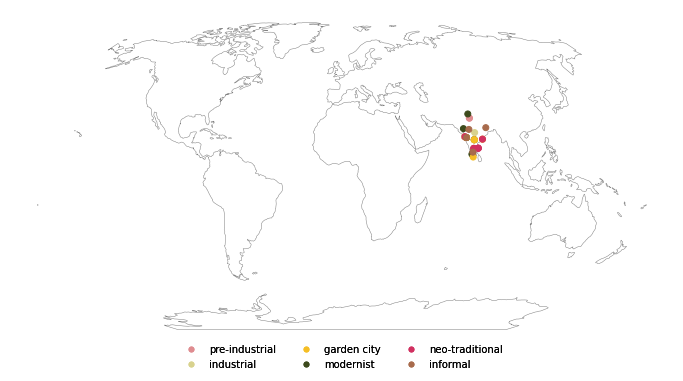

In [9]:
ax = world.plot(figsize=(12, 8), color="none", edgecolor="grey", linewidth=.5)
cases.plot(ax=ax, color=cases.period.map(symbology))
ax.set_axis_off()

# add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), ncol=3, loc="lower center", frameon=False, bbox_to_anchor=(0.5, -.1))
ax.add_artist(leg_points)
plt.savefig('figures/case_studies.png', bbox_inches='tight', dpi=300)